In [20]:
import pandas as pd
import numpy as np
from functions import *
from BarBuilder import *
from FeatureBuilder import *
from FeatureImportance import *
from CrossValidation import *
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.isotonic import IsotonicRegression
import quantstats as qs

import pickle
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, brier_score_loss
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

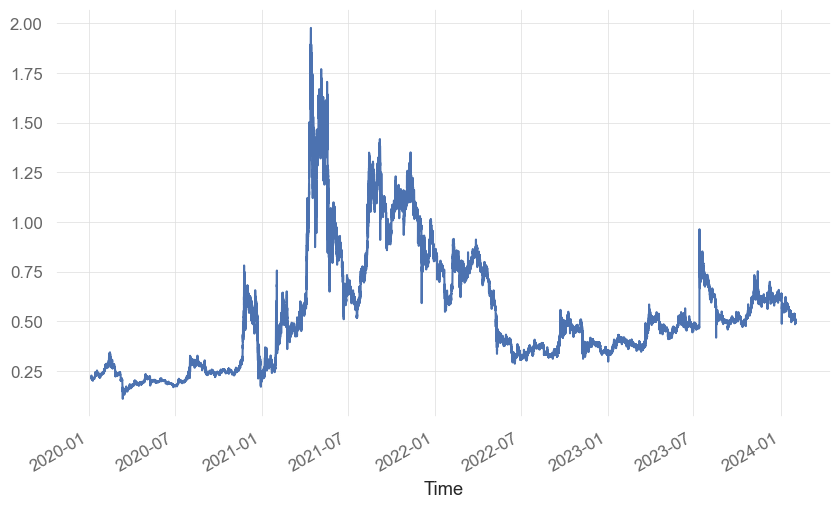

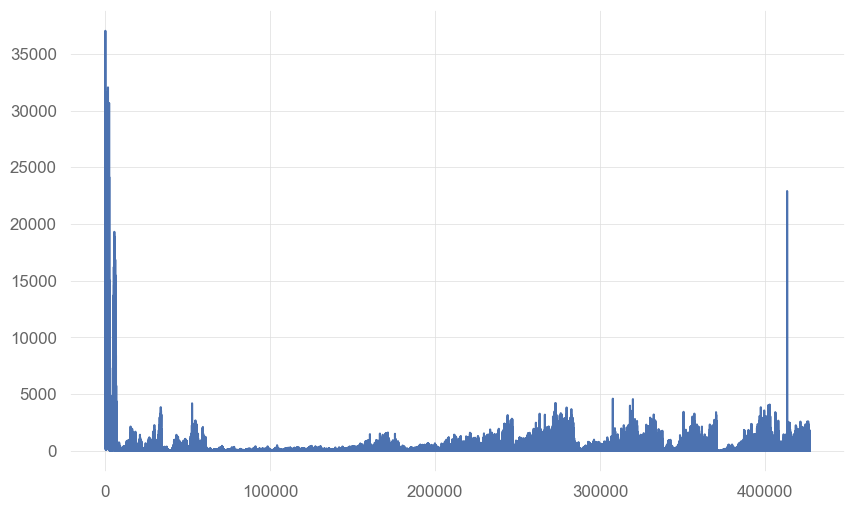

0 days 00:05:00.797562637


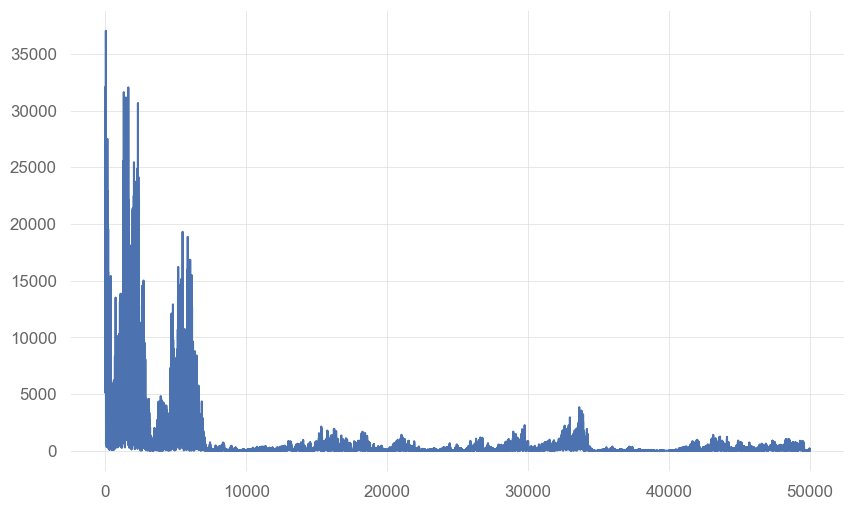

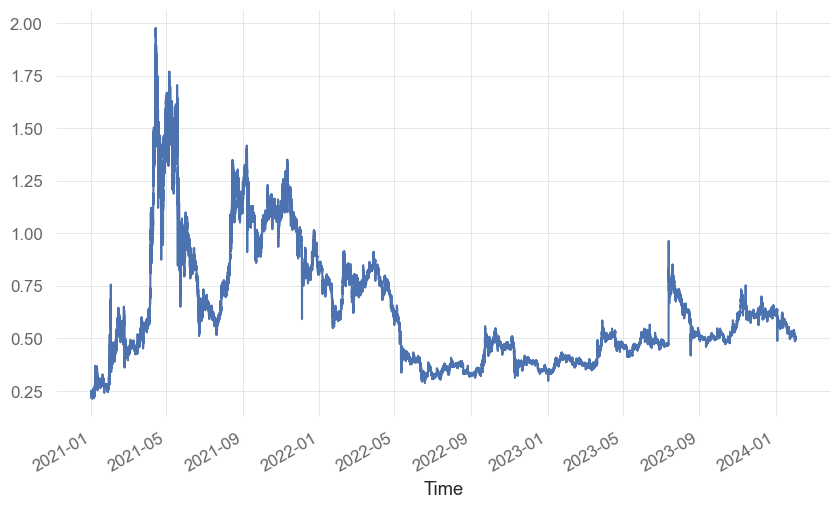

In [22]:
# Data Prep
df_ohlcv = pd.read_csv('data/alt_bars/XRPUSDT_dollar.csv', index_col=0)
# df_ohlcv = pd.read_csv('data/alt_bars/1000SHIBUSDT_dollar.csv', index_col=0)
df_ohlcv.Time = pd.to_datetime(df_ohlcv.Time)#, unit='ms')
df_ohlcv.set_index('Time', inplace=True)
df_ohlcv['barID'] = df_ohlcv.reset_index().index.values
df_ohlcv = df_ohlcv.reset_index().drop_duplicates(subset='Time', keep='first').set_index('Time')

# Price Plot
df_ohlcv.Close.plot(); plt.show()

# Time Plot
df_ohlcv.reset_index().Time.diff().dt.seconds.plot(); plt.show()
print(df_ohlcv.reset_index().Time.diff().mean())
df_ohlcv.reset_index().Time.diff().dt.seconds.iloc[:50000].plot();plt.show()

# Cut off
if True:
    # df_ohlcv = df_ohlcv.iloc[7500:] #25000 for XRP vol
    df_ohlcv = df_ohlcv.loc[pd.to_datetime("2021-01-01"):]
    df_ohlcv.Close.plot()
    plt.show()

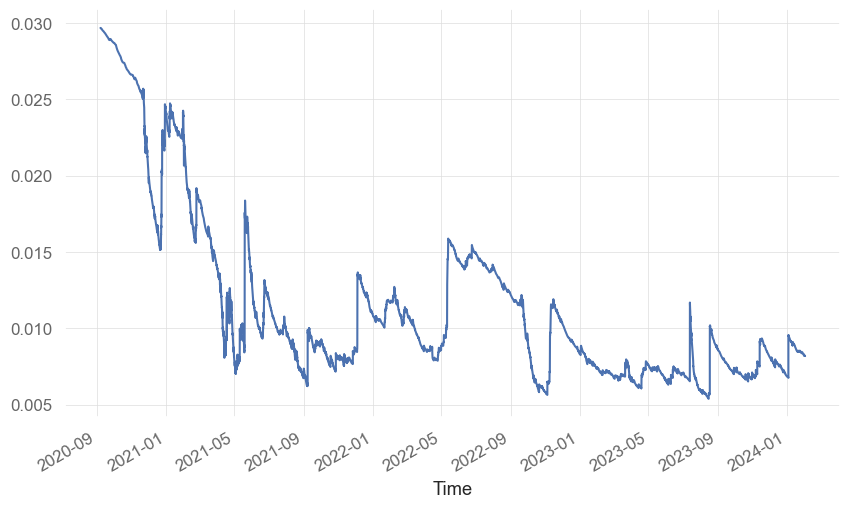

Opps per day: 16.765888978278358


In [4]:
# Cusum Sampling for 
numBars = 100
cusumVol = getVol(df_ohlcv.Close, span = 1e4, min_periods = 5e3, numBars = numBars, use_log = True)/3
cusumVol.plot(); plt.show()
h = cusumVol
tEvents, _ = get_cusum_events(np.log(df_ohlcv.Close)[-len(h):], h, use_neg=True, use_pos=False)
print("Opps per day:", pd.Series(index=tEvents, data=1).resample("D").sum().mean())

In [5]:
# Y
side = 'long'
commission = 0.0005
t1 = getVertBarrier(tEvents, df_ohlcv.Close, numBars = numBars)
vol = getVol(df_ohlcv.Close, span = 100, min_periods = 1e3, numBars = numBars, use_log = True)
events = getEvents(df_ohlcv.Close, tEvents, [0,0], vol, minRet = 0, num_cpu = 1, t1= t1)
Y = getBins(events,df_ohlcv.Close, use_log = True, commission = commission, side = side) # gets 'bins' and 'ret' 
Y['t1'] = events.t1
Y['entryP'], Y['exitP'], Y['barID'] = df_ohlcv.Close[Y.index], df_ohlcv.Close[Y.t1].values, df_ohlcv.barID[Y.index]
print("Average Duration:", (t1-t1.index).mean())

Average Duration: 0 days 06:22:27.573128137


In [6]:
# X
X = pd.DataFrame()
lookback = 100
for scale in [4, 8, 16]:
    X[f'blgr_{scale}x_{lookback}'] = blgr(events, df_ohlcv.Close, lookback, scale)        
for scale in [1]:  
    X[f'roc_{scale}x_{lookback}'] = roc(events, df_ohlcv.Close, lookback = lookback, scale = scale)       

# for scale in [4]:
#     X[f'blgr_{scale}x_{lookback}'] = blgr(events, df_ohlcv.Close, lookback, scale)


In [7]:
# XY Cleaning
current_time = pd.to_datetime("2024-03-01")
if True:
    X_hist, Y_hist = X[: current_time], Y[: current_time]
else:
    lookupPeriod = pd.Timedelta(days=365*2)
    X_hist, Y_hist = X[current_time - lookupPeriod : current_time], Y[current_time - lookupPeriod : current_time]

X_hist, Y_hist = X_hist.dropna(), Y_hist.loc[X_hist.index,:]

In [13]:
# Cross Validation

# Player Setting
leverage = 1
kellyFactor = 1
minThres = 0.6
prob_discount = 0
dP = 0.05 #discretization unit
room = 0
dT = numBars
thresholds = np.arange(55, 105, 5)
agg_players = []
outerCV = PurgedKFold(10, Y_hist['t1'], pctEmbargo=0.01)
players = {}

for i, (train, test) in enumerate(outerCV.split(X=X_hist, rightTrain = True)):
    
    if i < 1:  continue

    X0, X1 = X_hist.iloc[train,:].copy(), X_hist.iloc[test,:].copy()
    Y0, Y1 = Y_hist.iloc[train,:].copy(), Y_hist.iloc[test,:].copy()
    
    for selected_feature in X_hist.columns:

        # Estimator
        probaBin = probaBinning (X0[selected_feature], Y0.ret, minBin = -10, maxBin = 0, interval = 0.5)
        model = IsotonicRegression(increasing = False, y_max = 1, out_of_bounds = 'clip')
        model = model.fit(probaBin.feature.values, probaBin.prob.values)

        # BetDF
        proba = model.predict(X1[selected_feature])*100
        proba_discrete = roundDown(proba, dP*100, room = room)/100
        Y1['proba_discrete'] = proba_discrete
        betDF = Y1[proba_discrete>=minThres].copy()
        betDF['feature'] = X1[selected_feature].loc[betDF.index]

        # Remove Overlaps
        betDF['remove'] = False
        for j in range(0, len(betDF)-1): # Iterate through each bet
            current_row = betDF.iloc[j]
            if current_row['remove']:
                continue

            next_idx = j+1
            next_row = betDF.iloc[next_idx]
            overlapTime = next_row['barID'] - current_row['barID'] < dT
            while overlapTime:
                
                # Check dP
                overlapProba = (next_row['proba_discrete'] - current_row['proba_discrete']) < dP
                if overlapProba:
                    betDF.at[betDF.index[next_idx],'remove'] = True
                    next_idx += 1
                    if next_idx >= len(betDF): break
                    next_row = betDF.iloc[next_idx]
                    overlapTime = next_row['barID'] - current_row['barID'] < dT                    
                else:
                    break

        betDF_clean = betDF[~betDF['remove']].copy()#; betDF_clean.drop('remove', axis= 1, inplace=True)

        # Adjust Bet Size
        betDF_clean['betSize'] = ((betDF_clean['proba_discrete']-prob_discount)*2-1)*kellyFactor
        betDF_clean['feature'] = selected_feature

        # Adjust Updated Position
        if True:
            betDF_clean['overwritten'] = betDF_clean.t1.values > betDF_clean.index.to_series().shift(-1).values
            betDF_clean['exitP_adj'] = np.where(betDF_clean['overwritten'], betDF_clean['entryP'].shift(-1), betDF_clean['exitP'])
            betDF_clean['ret_adj'] = (betDF_clean['exitP_adj']/betDF_clean['entryP'] - 1)*betDF_clean['betSize']*leverage
            betDF_clean['ret_adj'] -= np.where(betDF_clean['overwritten'], commission, 2*commission)*betDF_clean['betSize']*leverage
            betDF_clean['ret_adj'] = np.log(1+betDF_clean['ret_adj'])
        else:
            betDF_clean['ret_adj'] = np.log(1+(np.exp(betDF_clean['ret']) - 1 )*betDF_clean['betSize']*leverage)
        
        if selected_feature in players.keys():
            players[selected_feature] = pd.concat([players[selected_feature], betDF_clean], axis= 0).sort_index()
        else:
            players[selected_feature] = betDF_clean
        

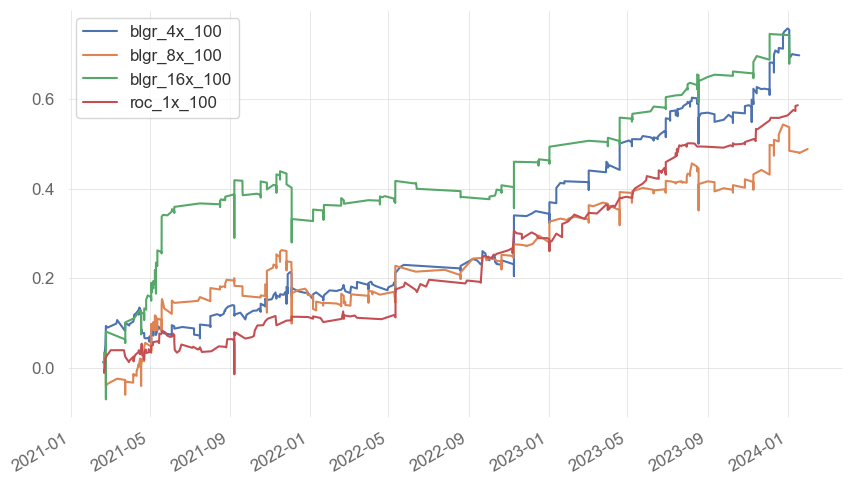

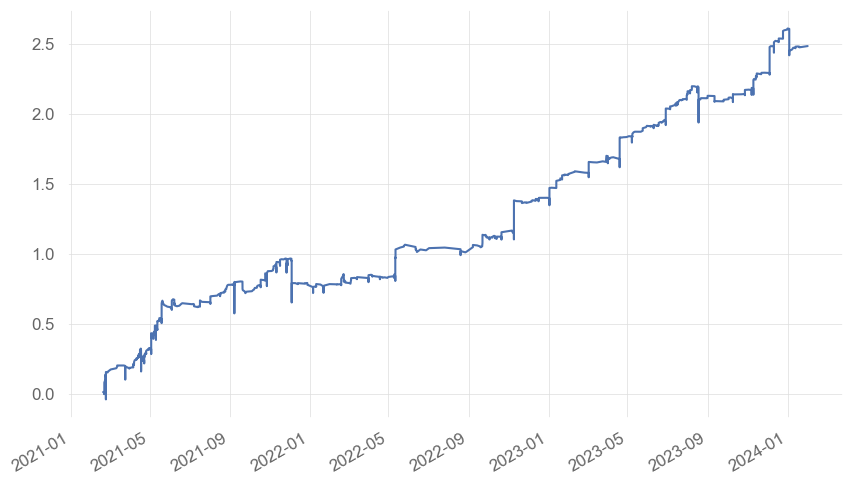

In [14]:
for name, player in players.items():
    player.ret_adj.cumsum().plot(label=name)
plt.legend(); plt.show()
combined = pd.concat([player for player in players.values()],axis = 0).sort_index()
combined.ret_adj.cumsum().plot();  plt.show(); 

In [19]:
combined.tail(20)

,ret,bin,t1,entryP,exitP,barID,proba_discrete,feature,remove,betSize,overwritten,exitP_adj,ret_adj
2024-01-03 12:01:47.124999936,-0.054850,0,2024-01-03 12:30:11.944999936,0.5900,0.5591,422096,0.95,blgr_4x_100,False,0.9,True,0.5700,-0.031448
2024-01-03 12:01:47.124999936,-0.054850,0,2024-01-03 12:30:11.944999936,0.5900,0.5591,422096,0.85,blgr_8x_100,False,0.7,True,0.5802,-0.012049
2024-01-03 12:08:22.776000000,-0.056007,0,2024-01-03 12:41:07.340999936,0.5854,0.5541,422119,0.75,blgr_16x_100,False,0.5,True,0.5802,-0.004702
2024-01-03 12:08:26.985999872,-0.044549,0,2024-01-03 12:41:50.792999936,0.5802,0.5555,422120,0.85,blgr_16x_100,False,0.7,True,0.5752,-0.006403
2024-01-03 12:08:26.985999872,-0.044549,0,2024-01-03 12:41:50.792999936,0.5802,0.5555,422120,0.90,blgr_8x_100,False,0.8,True,0.5700,-0.014570
2024-01-03 12:08:31.198000128,-0.034445,0,2024-01-03 12:42:27.292999936,0.5752,0.5563,422121,0.90,blgr_16x_100,False,0.8,True,0.5406,-0.049739
2024-01-03 12:08:32.423000064,-0.026074,0,2024-01-03 12:43:11.574000128,0.5700,0.5559,422122,1.00,blgr_4x_100,False,1.0,False,0.5559,-0.026074
2024-01-03 12:08:32.423000064,-0.026074,0,2024-01-03 12:43:11.574000128,0.5700,0.5559,422122,1.00,blgr_8x_100,False,1.0,False,0.5559,-0.026074
2024-01-03 12:09:38.814000128,0.032860,1,2024-01-03 12:50:14.328999936,0.5406,0.5592,422131,1.00,blgr_16x_100,False,1.0,False,0.5592,0.032860
2024-01-05 17:05:46.374000128,0.018326,1,2024-01-06 09:55:34.432000000,0.5540,0.5648,422816,0.60,blgr_4x_100,False,0.2,False,0.5648,0.003692


In [61]:
# Visual Evaluation
idx = np.searchsorted(combined.index, pd.to_datetime('2023-08-17 21:35:25.808999936'))

combined.iloc[idx-5:idx+2]



,ret,bin,t1,entryP,exitP,barID,proba_discrete,feature,remove,betSize,overwritten,exitP_adj,ret_adj
2023-08-16 20:29:35.768999936,0.012612,1,2023-08-17 00:47:57.043000064,0.5770,0.5849,392620,0.55,-2.837900,False,0.1,False,0.5849,0.001268
2023-08-17 14:42:34.108999936,-0.006532,0,2023-08-17 17:31:43.371000064,0.5807,0.5775,392827,0.55,-3.975599,False,0.1,False,0.5775,-0.000651
2023-08-17 16:07:48.067000064,-0.010549,0,2023-08-17 21:17:50.513999872,0.5688,0.5634,392883,0.55,-2.714405,False,0.1,False,0.5634,-0.001050
2023-08-17 20:35:00.935000064,-0.177989,0,2023-08-17 21:47:09.336999936,0.5702,0.4778,392952,0.55,-3.775737,False,0.1,False,0.4778,-0.016439
2023-08-17 21:27:09.129999872,-0.143196,0,2023-08-17 21:56:40.689999872,0.5596,0.4855,392986,0.55,-2.644675,False,0.1,True,0.5367,-0.004151
2023-08-17 21:37:20.867000064,-0.107484,0,2023-08-17 22:01:21.534000128,0.5500,0.4945,392998,0.55,-2.835465,False,0.1,True,0.5322,-0.003292
2023-08-17 21:37:20.867000064,-0.107484,0,2023-08-17 22:01:21.534000128,0.5500,0.4945,392998,0.55,-2.967327,False,0.1,True,0.5418,-0.001542
